In [1]:
import collections
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
import matplotlib.pyplot as plt
from tqdm import tqdm

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity) # double-ended queue with a fixed maximum length

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size) # list[tuple(state, action, reward, next_state, done)]
        states, actions, rewards, next_states, dones = zip(*transitions) # unzip the list of tuples
        # states = (transition[0] for transition in transitions)
        return np.array(states), actions, rewards, np.array(next_states), dones
    
    def __len__(self):
        return len(self.buffer)

In [2]:
class Qnet(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [3]:
class DQN:
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim, action_dim).to(device)
        self.target_q_net = Qnet(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update # target network update frequency
        self.device = device
        self.learn_step_counter = 0 # for target network update

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim) # (1)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item() # return the index of the max value
        return action
    
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        # use value of the action replace the dimension of original index, then gather values by new index
        # states: (batch_size, state_dim) -> (batch_size, action_dim)
        # actions: (batch_size, 1)
        # q_values: (batch_size, 1)
        q_values = self.q_net(states).gather(1, actions)
        # next_states: (batch_size, state_dim) -> (batch_size, action_dim)
        # max on dim 1: (batch_size, (values, indices))[0] -> (batch_size,)
        # view: (batch_size, 1)
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        # TD target
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)

        dqn_loss = F.mse_loss(q_values, q_targets)
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.learn_step_counter % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict()) # copy parameters from q_net to target_q_net
        self.learn_step_counter += 1

In [4]:
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
env.action_space.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()[0]
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done = env.step(action)[0:3]
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                if replay_buffer.__len__() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_36885/1756068494.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 50/50 [00:20<00:00,  2.41it/s, episode=500, return=573.300]


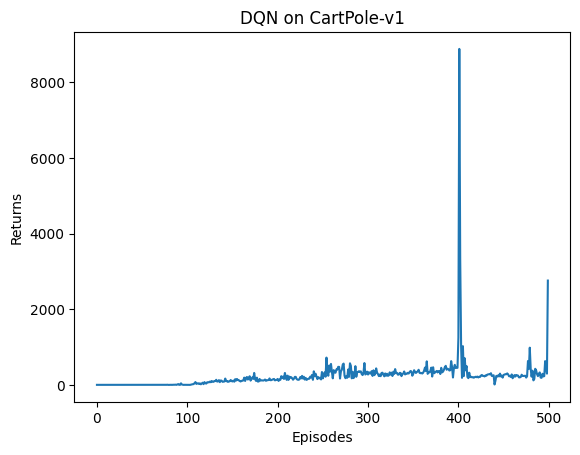

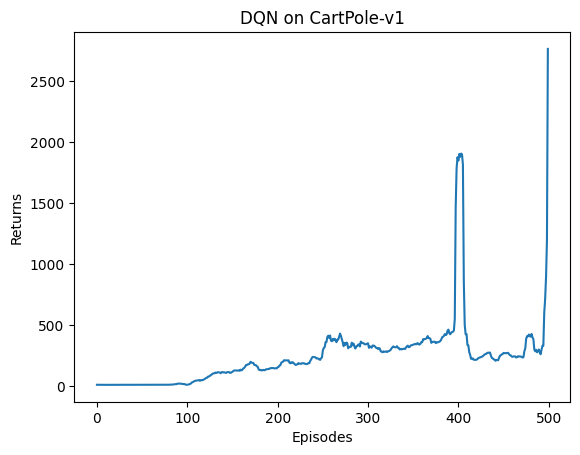

In [6]:
from rl_utils import moving_average

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()